# Google drive mount
#### * google colab 사용 시, google drive 내 데이터를 사용하기 위한 절차입니다

In [ ]:
# google drive에 있는 데이터를 사용하기 위해 접근

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GPU Test
#### * 현재 코랩에서 GPU 사용이 가능한지 테스트하는 절차입니다

In [ ]:
# tensorflow를 import 하고, 현재 colab에서 gpu 구동이 되고 있는지 테스트 하는 코드
# Found GPU at: /device:GPU ~ 가 뜨면 성공

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# library import
#### 모듈 사용을 위해 import 하는 절차입니다

In [ ]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

# 필요 library import
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, concatenate, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Data load
#### * Model 학습에 사용할 데이터를 불러오는 절차입니다

In [ ]:
# data 경로(데이터가 있는 경로에 맞게 바꿔주셔야 합니다.)
data_path = './drive/MyDrive/숨고/전광호님(가짜 뉴스 분류)/' 

# data load
data = pd.read_csv(data_path + "Mission1_sample_1차수정본.csv")

data.head()

,식별자,뉴스제목,뉴스본문,Label
0,1_00001,"""술상 차려와라""…갑질한 39사단장 승진",운전병과 공관병에게 폭언과 불합리한 지시로 '갑질' 논란을 불러일으킨 육군 제39사...,1
1,1_00002,"고민정 부대변인 ""새벽 5시 30분부터 저녁 9시까지 중간에 쉬는 시간 없이 일한다""",고민정(38) 청와대 부대변인이 출퇴근시간을 공개했다.\n\n2일 네이버TV에 KT...,1
2,1_00003,"똑똑해진 구글 번역기, '문장' 아닌 '단어'를 번역하는 방식의 신경망 기계번역","똑똑해진 ""구글 번역기를 이용해 더 이상 영어를 공부할 필요가 없는 시대가 올까?""...",1
3,1_00004,"블루핸즈자동차, ‘수해 특별점검 서비스’ 실시",현대·기아자동차가 수해가 자주 발생하는 기간인 7월 1일부터 10월 31일까지 집중...,1
4,1_00005,PC 게임 '어쌔신 크리드3' 유료로 배포된다,유비소프트가 창립 30주년을 기념해 PC 게임 ‘어쌔신 크리드3’를 무료 증정한다....,1


# EDA
#### * 주어진 데이터로 간단한 분석을 실시합니다

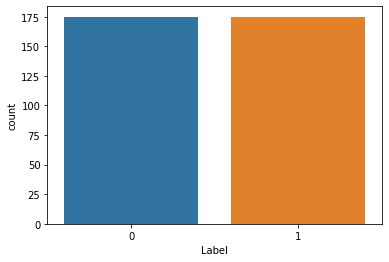

In [ ]:
# 데이터 내 진짜(0), 가짜(1) 의 각 비율 확인
sns.countplot(data = data, x='Label')

In [ ]:
# 가짜 뉴스의 제목과 진짜 뉴스의 겹치는 제목 수
real_news_title = set(data[data['Label'] == 1]['뉴스제목'].unique()) 
fake_news_title = set(data[data['Label'] == 0]['뉴스제목'].unique())
print("제목이 겹치는 기사 수 :", len(real_news_title & fake_news_title))
print("제목이 겹치는 비율 :", len(real_news_title & fake_news_title)/data['뉴스제목'].nunique())

제목이 겹치는 기사 수 : 0
제목이 겹치는 비율 : 0.0


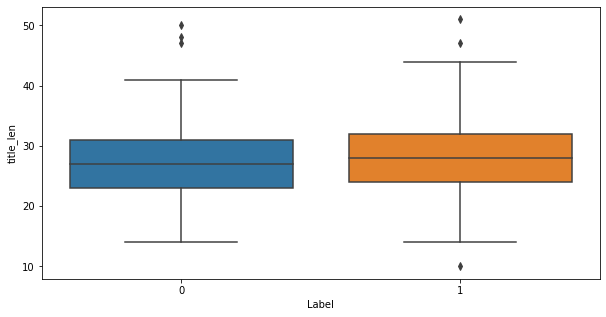

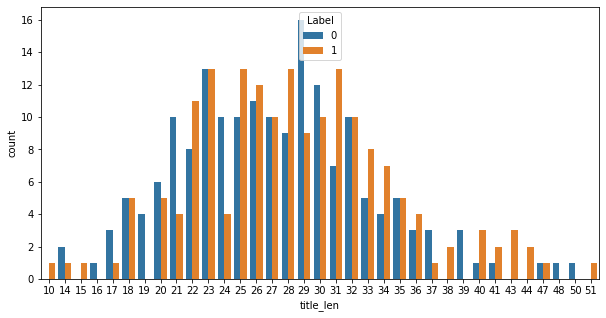

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


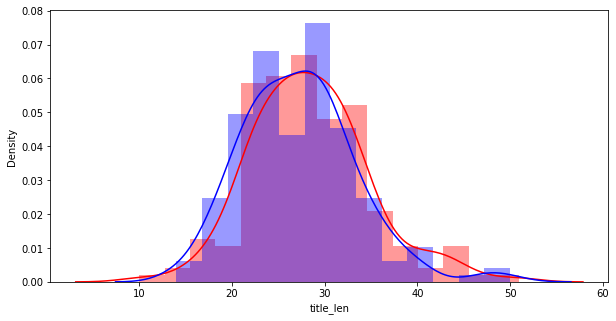

In [ ]:
# 제목 길이에 대한 분석
data['title_len'] = data['뉴스제목'].apply(lambda x : len(x))

plt.figure(figsize=(10,5))
sns.boxplot(data = data, y='title_len', x='Label')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data = data, x='title_len', hue='Label')
plt.show()

plt.figure(figsize=(10,5))
sns.distplot(data[data['Label'] == 1]['title_len'], color='red', label='1')
sns.distplot(data[data['Label'] == 0]['title_len'], color='blue', label='0')

In [ ]:
# 가짜 뉴스의 내용과 진짜 뉴스의 겹치는 내용 수
real_news_content = set(data[data['Label'] == 1]['뉴스본문'].unique()) 
fake_news_content = set(data[data['Label'] == 0]['뉴스본문'].unique())
print("내용이 겹치는 기사 수 :", len(real_news_content & fake_news_content))
print("내용이 겹치는 비율 :", len(real_news_content & fake_news_content)/data['뉴스본문'].nunique())

내용이 겹치는 기사 수 : 1
내용이 겹치는 비율 : 0.0028653295128939827


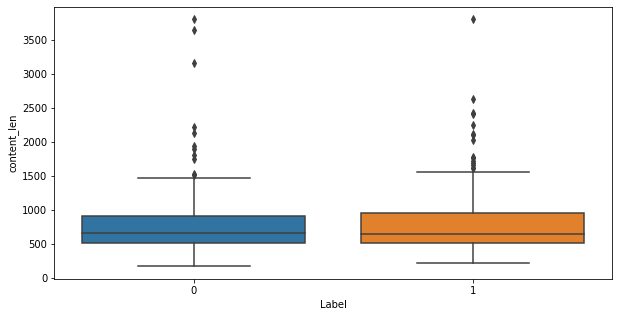

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


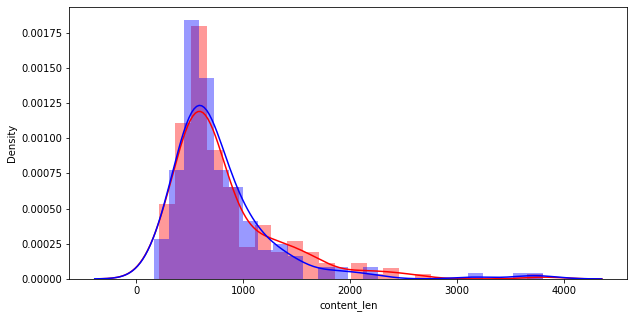

In [ ]:
# 내용 길이에 대한 분석
data['content_len'] = data['뉴스본문'].apply(lambda x : len(x))

plt.figure(figsize=(10,5))
sns.boxplot(data = data, y='content_len', x='Label')
plt.show()

plt.figure(figsize=(10,5))
sns.distplot(data[data['Label'] == 1]['content_len'], color='red', label='1')
sns.distplot(data[data['Label'] == 0]['content_len'], color='blue', label='0')

# NLP 진행
#### mecab을 이용한 전처리 및 형태소 분석

In [ ]:
# stopword 불러오기
f = open(data_path + "koreanStopwords.txt", 'r')
lines = f.readlines()
stopwords = []
for line in lines:
    line = line.replace('\n', '')
    stopwords.append(line)
f.close()

stopwords = stopwords+['간','갑','갤','걸','게','겠','고','과','구','꺼','꺾','꼽','끌','끼','낳','넘','놓','뉴','는','늘',
           '니','다','대','던','도','돼','됐','된','됨','듯','딩','딱','딸','뜨','라','러','렉','렌','로','록','론','롭',
           '를','마','막','만','맑','맞','맨','맷','먹','먼','며','면','무','문','미','및','바','박','백','본','새','생','쉽',
           '시','식','신','실','써','썼','쏘','쓰','쓴','씩','아','악','았','애','앱','약','양','어','억','었','에','엔','여',
           '열','올','와','유','율','은','을','음','의','자','작','잔','재','잭','저','전','정','제','젤','조','족',
           '준','줄','질','짓','째','쯔','쯤','찌','첨','초','출','취','측','치','쿡','퀘','탈','탑','테','통','트','튼',
           '판','팟','팬','평','폰','표','할','해','했','혼','화','후']

In [ ]:
# stopword 처리 및 형태소 추출 
mecab = Mecab()

def preprocessing(text_list):
    korean = re.compile('[^ ㄱ-ㅣ가-힣]+')

    preprocessed_text = []
    for text in text_list:
        text = korean.sub('', str(text))
        tokens = mecab.morphs(text)
        tokens = [token for token in tokens if token not in stopwords]
        preprocessed_text.append(tokens)

    return preprocessed_text

data['processed_title'] = preprocessing(data['뉴스제목'])
data['processed_content'] = preprocessing(data['뉴스본문'])

In [ ]:
def text_to_sequence(text, max_len=1000):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    text_sequence = tokenizer.texts_to_sequences(text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    text_sequence = pad_sequences(text_sequence, maxlen = max_len)
    return text_sequence, vocab_size

y_data = data['Label']
x_data_title, title_vocab_size = text_to_sequence(data['processed_title'], max_len = 50)
x_data_content, content_vocab_size = text_to_sequence(data['processed_content'], max_len = 1000)
print(x_data_title.shape, x_data_content.shape)

vocab_size :  1474
vocab_size :  10084
(350, 50) (350, 1000)


In [ ]:
# train/test split
x_train_title,x_test_title,x_train_content,x_test_content,y_train,y_test = train_test_split(x_data_title, x_data_content,y_data, test_size = 0.2, random_state=20220830, stratify=y_data)


# Training Model
#### * 모델 학습을 위한 과정입니다.(모델은 LSTM 모델을 사용하였습니다)

In [ ]:
## lstm layer 생성
title_timestep = 50
title_column = title_vocab_size
content_timestep = 50
content_column = content_vocab_size
learning_rate = 0.0001
batch_size = 16
epochs = 300

def model(emb_input, timesteps, max_words):
	# lstm model
    emb_model = Embedding(max_words, 50, input_length=timesteps)(emb_input)
    # lstm_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))(emb_model)
    # lstm_out = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3))(emb_model)
    lstm_out = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3))(emb_model)

    return lstm_out

# title process
title_input = Input(shape=(None,))
title_model = model(title_input, title_timestep, title_column)
title_model = Flatten()(title_model)

# content process
content_input = Input(shape=(None,))
content_model = model(content_input, content_timestep, content_column)
content_model = Flatten()(content_model)

# concatenate
concatenated = concatenate([title_model, content_model])
concatenated = Dense(64, activation='relu',kernel_initializer='he_normal')(concatenated)
concatenated = BatchNormalization()(concatenated)
concatenated = Dense(32, activation='relu',kernel_initializer='he_normal')(concatenated)
concatenated = BatchNormalization()(concatenated)
concat_out = Dense(1, activation='sigmoid')(concatenated)

concat_model = Model([title_input, content_input], concat_out)

optimizer = optimizers.Adam(learning_rate=learning_rate) # optimizer 지정 

# model의 loss function, 사용할 optimizer, metirc 정의
concat_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']) 

concat_model.summary() # 모델 전체 아키텍처 출력

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_22 (Embedding)       (None, None, 50)     73700       ['input_23[0][0]']               
                                                                                                  
 embedding_23 (Embedding)       (None, None, 50)     504200      ['input_24[0][0]']               
                                                                                           

In [ ]:
best_weights_file="./drive/MyDrive/숨고/전광호님(가짜 뉴스 분류)/weights.best.hdf5" # 학습 중 최상의 모델을 저장할 경로
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # 학습 중 validation acc 기준 최상의 모델을 저장하도록 checkpoint 설정
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

# model 학습 설정 및 학습 진행(주입할 input, label 데이터/batch_size/epochs/모델 저장/학습과정출력여부/학습 중 val_loss를 계산할 데이터비율, epoch마다 셔플 여부)
history = concat_model.fit([x_train_title, x_train_content], y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint, es] ,
        verbose=1,
        validation_split=0.1,
        shuffle=True)

# Model validation
#### * 만들어진 모델의 성능을 평가하기 위한 파트입니다.(accuracy로 평가)

3/3 [==============================] - 0s 88ms/step - loss: 0.7089 - accuracy: 0.4429

Accuracy: 0.4429


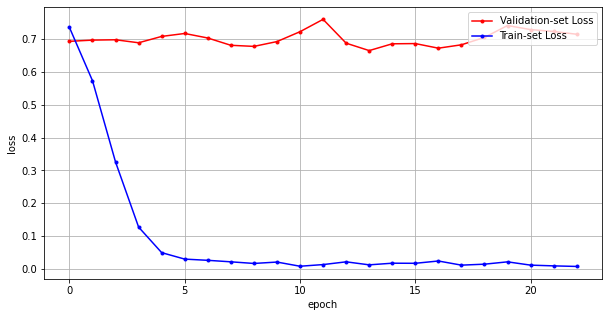

In [ ]:
concat_model.load_weights(best_weights_file)

## 위에서 분리해둔 test set에 대하여 모델 정확도 반환
print('\nAccuracy: {:.4f}'.format(concat_model.evaluate([x_test_title, x_test_content], y_test)[1])) 

y_vloss = history.history['val_loss'] # 학습 중 validation loss 저장
y_loss = history.history['loss'] # 학습 중 train loss 저장
x_len = np.arange(len(y_loss)) # 전체 epoch 길이 저장(현재 500)

plt.figure(figsize=(10,5))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss") # validation loss에 대한 그래프 출력
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss") # train loss에 대한 그래프 출력
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
 # Metrics for confusion matrix
y_pred = pd.DataFrame(model.predict([x_test_title, x_test_content]),columns=['predict_label'])
y_pred[y_pred['predict_label']>=0.5] = 1
y_pred[y_pred['predict_label']<0.5] = 0
target_names = ['0','1']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:
# auroc
auroc_score = roc_auc_score(y_test, y_pred, average=None)
print("AUROC : ", round(auroc_score,2))

# roc curve graph
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = model.predict([x_test_title, x_test_content]])
fper, tper, thresholds = roc_curve(y_test, prob)
plot_roc_curve(fper, tper)